# CNN
## 1. Load Dataset

In [16]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
from torch.utils.data import DataLoader

In [18]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) ])

# Download the MNIST training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:00<00:00, 83.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 40.1MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 78.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.09MB/s]


In [27]:
# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

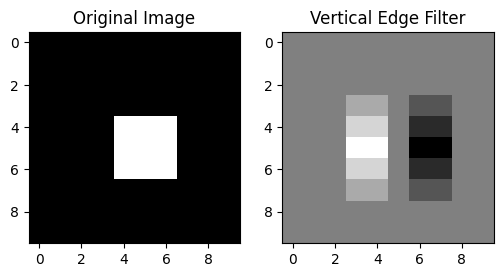

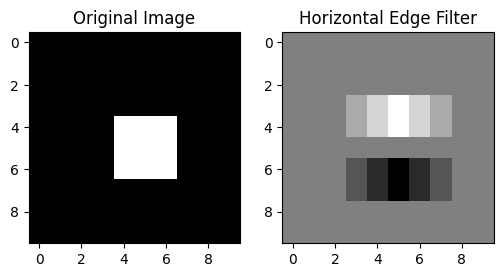

In [28]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def plot_convolution(filter_tensor, filter_name):

    test_image = torch.zeros(1, 1, 10, 10)
    test_image[0, 0, 4:7, 4:7] = 1

    # Apply the filter using 2D convolution
    filtered_image = F.conv2d(test_image, filter_tensor.unsqueeze(0).unsqueeze(0), padding=1)

    # Convert tensor to numpy for visualization
    filtered_image = filtered_image.squeeze().detach().numpy()

    # Plot the original and filtered images
    plt.figure(figsize=(6, 3))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(test_image.squeeze(), cmap='gray')
    plt.title("Original Image")

    # Filtered Image
    plt.subplot(1, 2, 2)
    plt.imshow(filtered_image, cmap='gray')
    plt.title(filter_name)

    plt.show()

# Vertical edge filter
vertical_filter = torch.tensor([[-1., 0., 1.],
                                [-1., 0., 1.],
                                [-1., 0., 1.]])
plot_convolution(vertical_filter, 'Vertical Edge Filter')

# Horizontal edge filter
horizontal_filter = torch.tensor([[-1., -1., -1.],
                                  [ 0.,  0.,  0.],
                                  [ 1.,  1.,  1.]])
plot_convolution(horizontal_filter, 'Horizontal Edge Filter')


## 2. Build a CNN Network

In [29]:
# Define a CNN network
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184,10)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = OneConv()

summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

## 3. Train the model

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the train function
def train(model, train_loader, test_loader, epochs):
    """
    Trains the given model on the training data and evaluates it on the test data.

    Args:
        model: The neural network model to train.
        train_loader: DataLoader for the training dataset.
        test_loader: DataLoader for the test dataset.
        epochs: Number of training epochs.

    Returns:
        A dictionary containing the training and test losses and accuracies for each epoch.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Store the training history
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_samples = 0

        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training")):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_correct += (predicted == target).sum().item()
            total_samples += target.size(0)


        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / total_samples
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        total_samples = 0

        with torch.no_grad():
            for data, target in tqdm(test_loader, desc=f"Epoch {epoch + 1}/{epochs} - Testing"):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                test_correct += (predicted == target).sum().item()
                total_samples += target.size(0)

        avg_test_loss = test_loss / len(test_loader)
        test_acc = test_correct / total_samples
        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return history

In [31]:
# Train the Model
hist = train(net,train_loader,test_loader,epochs=5)

Epoch 1/5 - Testing: 100%|██████████| 157/157 [00:02<00:00, 53.89it/s]


Epoch 1/5 - Train Loss: 0.2061, Train Acc: 0.9396, Test Loss: 0.0835, Test Acc: 0.9739


Epoch 2/5 - Testing: 100%|██████████| 157/157 [00:03<00:00, 48.26it/s]


Epoch 2/5 - Train Loss: 0.0757, Train Acc: 0.9771, Test Loss: 0.0585, Test Acc: 0.9806


Epoch 3/5 - Testing: 100%|██████████| 157/157 [00:02<00:00, 56.69it/s]


Epoch 3/5 - Train Loss: 0.0580, Train Acc: 0.9822, Test Loss: 0.0593, Test Acc: 0.9807


Epoch 4/5 - Testing: 100%|██████████| 157/157 [00:02<00:00, 64.14it/s]


Epoch 4/5 - Train Loss: 0.0463, Train Acc: 0.9861, Test Loss: 0.0636, Test Acc: 0.9809


Epoch 5/5 - Testing: 100%|██████████| 157/157 [00:02<00:00, 62.74it/s]

Epoch 5/5 - Train Loss: 0.0405, Train Acc: 0.9875, Test Loss: 0.0578, Test Acc: 0.9819


## 4. Visualize the Predictions

In [32]:
# Define the plot_results function
def plot_results(hist):
    """
    Plots the training and test losses and accuracies.

    Args:
        hist: A dictionary containing the training and test losses and accuracies for each epoch.
    """
    plt.figure(figsize=(12, 4))

    # Plot training and test loss
    plt.subplot(1, 2, 1)
    plt.plot(hist['train_loss'], label='Train Loss')
    plt.plot(hist['test_loss'], label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(hist['train_acc'], label='Train Accuracy')
    plt.plot(hist['test_acc'], label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

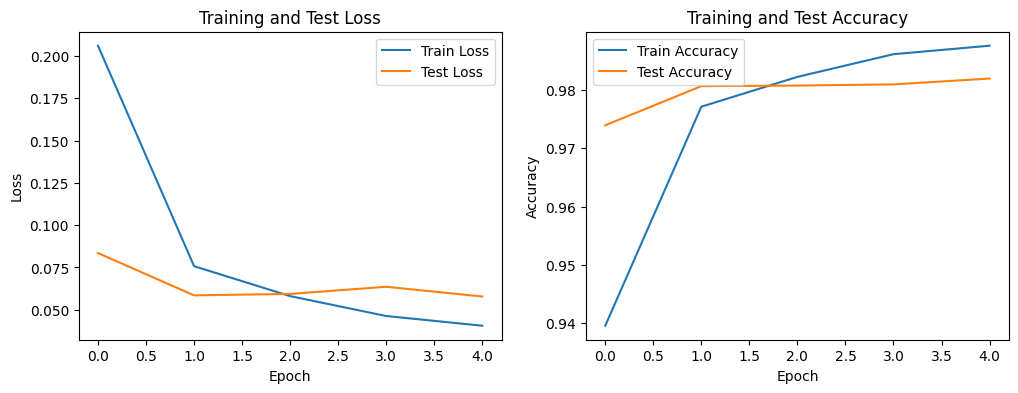

In [33]:
plot_results(hist)

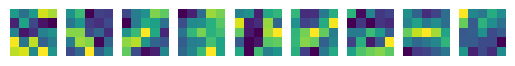

In [34]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

## MultiLayered CNN and Pooling Layer

In [35]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

In [36]:
hist = train(net,train_loader,test_loader,epochs=5)

Epoch 1/5 - Testing: 100%|██████████| 157/157 [00:03<00:00, 48.74it/s]


Epoch 1/5 - Train Loss: 0.2226, Train Acc: 0.9379, Test Loss: 0.0746, Test Acc: 0.9768


Epoch 2/5 - Testing: 100%|██████████| 157/157 [00:03<00:00, 48.60it/s]


Epoch 2/5 - Train Loss: 0.0663, Train Acc: 0.9801, Test Loss: 0.0459, Test Acc: 0.9849


Epoch 3/5 - Testing: 100%|██████████| 157/157 [00:03<00:00, 48.65it/s]


Epoch 3/5 - Train Loss: 0.0480, Train Acc: 0.9851, Test Loss: 0.0375, Test Acc: 0.9883


Epoch 4/5 - Testing: 100%|██████████| 157/157 [00:04<00:00, 38.98it/s]


Epoch 4/5 - Train Loss: 0.0388, Train Acc: 0.9880, Test Loss: 0.0491, Test Acc: 0.9850


Epoch 5/5 - Testing: 100%|██████████| 157/157 [00:03<00:00, 42.51it/s]

Epoch 5/5 - Train Loss: 0.0332, Train Acc: 0.9898, Test Loss: 0.0336, Test Acc: 0.9886


In [37]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:01<00:00, 102MB/s]


In [45]:
# Building a model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet()

summary(net,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the train function
def train(model, train_loader, test_loader, epochs, **kwargs): # Add **kwargs to accept additional keyword arguments
    """
    Trains the given model on the training data and evaluates it on the test data.

    Args:
        model: The neural network model to train.
        train_loader: DataLoader for the training dataset.
        test_loader: DataLoader for the test dataset.
        epochs: Number of training epochs.
        **kwargs: Additional keyword arguments, including 'optimizer' and 'loss_fn'.

    Returns:
        A dictionary containing the training and test losses and accuracies for each epoch.
    """
    optimizer = kwargs.get('optimizer', optim.Adam(model.parameters()))
    criterion = kwargs.get('loss_fn', nn.CrossEntropyLoss())
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Store the training history
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_samples = 0

        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training")):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_correct += (predicted == target).sum().item()
            total_samples += target.size(0)


        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / total_samples
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        total_samples = 0

        with torch.no_grad():
            for data, target in tqdm(test_loader, desc=f"Epoch {epoch + 1}/{epochs} - Testing"):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                test_correct += (predicted == target).sum().item()
                total_samples += target.size(0)

        avg_test_loss = test_loss / len(test_loader)
        test_acc = test_correct / total_samples
        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return history


In [51]:
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net, trainloader, testloader, epochs=3, optimizer=opt, loss_fn=nn.CrossEntropyLoss())

Epoch 1/3 - Testing: 100%|██████████| 715/715 [00:05<00:00, 134.38it/s]


Epoch 1/3 - Train Loss: 1.6247, Train Acc: 0.3988, Test Loss: 1.4868, Test Acc: 0.4547


Epoch 2/3 - Testing: 100%|██████████| 715/715 [00:05<00:00, 124.67it/s]


Epoch 2/3 - Train Loss: 1.4296, Train Acc: 0.4778, Test Loss: 1.3798, Test Acc: 0.4876


Epoch 3/3 - Testing: 100%|██████████| 715/715 [00:04<00:00, 149.34it/s]

Epoch 3/3 - Train Loss: 1.3190, Train Acc: 0.5229, Test Loss: 1.3079, Test Acc: 0.5289
